# Notebook 03: Centrality Analysis – Rankings and Mechanisms

---

## Research Questions

This notebook addresses four core questions about structural centrality in the US airport network:

1. **Which airports are structurally central under multiple centrality notions?**  
   Are the same airports consistently top-ranked across degree, betweenness, PageRank, and other metrics, or do different measures identify different critical nodes? Cross-metric consistency would suggest robust hub identification, while divergence would indicate metric-specific interpretation requirements.

2. **Do centrality distributions indicate extreme concentration or broad participation?**  
   Are centrality metrics heavy-tailed (a few mega-hubs dominate) or more evenly distributed? The shape of these distributions reveals whether the network operates under hub-and-spoke oligopoly versus distributed connectivity, with implications for robustness and operational risk concentration.

3. **Which airports are plausible "connectors" (bridges) versus "volume hubs"?**  
   Can we distinguish airports with high betweenness centrality (lying on many shortest paths) but moderate degree (structural bridges) from mega-hubs that rank high on all metrics? Identifying pure connectors reveals geographic or strategic bottlenecks distinct from volume-driven centrality.

4. **How do centrality patterns reflect airline hub-and-spoke strategies and geographic positioning?**  
   Do observed centrality rankings align with known carrier hub locations (AA at DFW, UA at DEN/ORD, DL at ATL)? To what extent does central geographic positioning (avoiding coastal extremes) inflate betweenness independently of airline decisions? Understanding these mechanisms contextualizes whether centrality is "designed" (strategic) or "emergent" (geographic).

---

## Key Findings Summary

**Cross-Metric Consistency – The "Big Four" Mega-Hubs:**  
DFW (Dallas-Fort Worth) and DEN (Denver) dominate across all 6 centrality metrics, consistently ranking #1-#2. DFW ranks #1 in degree (186 destinations), while DEN ranks #1 in betweenness (21,576) and PageRank (0.032). ORD (Chicago O'Hare) and ATL (Atlanta) consistently rank #3-#4, forming a stable "Big Four" critical infrastructure set regardless of metric choice.

**Extreme Hub Concentration:**  
All centrality distributions exhibit heavy tails requiring log-scale visualization. Mean degree = 19.5, but top airports exceed 180 destinations (9× mean). Betweenness concentration is even steeper: mean = 466, but DEN/DFW exceed 21,000 (45× mean). The top 5% of airports account for a disproportionate share of network connectivity.

**Scarcity of Pure "Connectors":**  
16 mega-hubs rank in the top 5% on both betweenness AND degree (DFW, DEN, ORD, ATL, CLT, LAS, MSP, PHX, LAX, IAH, DTW, SLC, SEA, DCA, FLL, MCO). Only 1 pure "connector" identified: **JNU (Juneau, Alaska)** – ranks 95th percentile for betweenness but 51st percentile for degree, reflecting its geographic isolation as a critical gateway to Alaskan communities with limited alternate routes.

**Geographic and Strategic Mechanisms:**  
DEN's slight PageRank advantage over DFW (0.032 vs 0.031) despite lower degree suggests DEN connects to better-connected airports (reinforcement effect). ANC (Anchorage) ranks #6 in betweenness (7,787) but lower in degree, confirming geographic bottleneck role for Alaska traffic. Central US locations (DFW, DEN, ORD) naturally reduce shortest-path distances to both coasts, inflating betweenness independently of airline strategy.

---

## Table of Contents
1. [Research Questions and Key Findings](#top)
2. [Setup and Imports](#setup)
3. [Discover Centrality Artifacts](#discover)
4. [Load and Inspect Centrality Data](#load)
5. [Top-K Rankings by Metric](#top-k)
6. [Centrality Distributions](#distributions)
7. [Connector vs Hub Analysis](#connector-hub)
8. [Interpretation](#interpretation)
9. [Write Report Outputs](#write-outputs)
10. [Reproducibility Notes](#reproducibility)

<a id="setup"></a>

In [1]:
# ============================================================================
# SETUP AND IMPORTS
# ============================================================================

import json
from pathlib import Path
from datetime import datetime
import warnings

import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Project paths
REPO_ROOT = Path.cwd().parent.parent
RESULTS_DIR = REPO_ROOT / "results"
ANALYSIS_DIR = RESULTS_DIR / "analysis"
TABLES_REPORT_DIR = RESULTS_DIR / "tables" / "report"
FIGURES_REPORT_DIR = RESULTS_DIR / "figures" / "report"
WARNINGS_LOG = TABLES_REPORT_DIR / "_warnings.log"

# Notebook identity
NOTEBOOK_ID = "nb03"
NOTEBOOK_NAME = "centrality__rankings_and_mechanisms"

# Plotting settings
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")

# Ensure output directories exist
TABLES_REPORT_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_REPORT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Analysis dir exists: {ANALYSIS_DIR.exists()}")

Analysis dir exists: True


In [2]:
# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def append_warning(message: str, notebook_id: str = NOTEBOOK_ID):
    """Append a warning to the consolidated warnings log."""
    timestamp = datetime.now().isoformat()
    with open(WARNINGS_LOG, "a") as f:
        f.write(f"[{timestamp}] [{notebook_id}] {message}\n")
    print(f"WARNING: {message}")

def safe_load_parquet(path: Path) -> pl.DataFrame | None:
    """Safely load a parquet file, returning None if it fails."""
    try:
        return pl.read_parquet(path)
    except Exception as e:
        append_warning(f"Failed to load {path.name}: {e}")
        return None

def get_top_k(df: pl.DataFrame, metric_col: str, id_col: str, k: int = 20) -> pd.DataFrame:
    """Get top-k entries by a metric with stable tie-breaking."""
    return (
        df
        .sort([metric_col, id_col], descending=[True, False])  # Tie-break by ID ascending
        .head(k)
        .with_row_index("rank", offset=1)
        .to_pandas()
    )

<a id="discover"></a>
## 2. Discover Centrality Artifacts

Search for files containing centrality-related keywords.

In [3]:
# ============================================================================
# DISCOVER CENTRALITY ARTIFACTS
# ============================================================================

centrality_keywords = ["centrality", "pagerank", "betweenness", "closeness", "eigen", "degree"]

# Search in analysis directory
analysis_files = list(ANALYSIS_DIR.glob("*.parquet")) + list(ANALYSIS_DIR.glob("*.csv"))
centrality_candidates = [
    f for f in analysis_files 
    if any(kw in f.name.lower() for kw in centrality_keywords)
]

print(f"Found {len(centrality_candidates)} centrality-related artifacts:")
for cf in centrality_candidates:
    print(f"  - {cf.name}")

# Select primary centrality file
primary_centrality_file = None
for candidate in ["airport_centrality.parquet", "centrality.parquet"]:
    path = ANALYSIS_DIR / candidate
    if path.exists():
        primary_centrality_file = path
        break

if primary_centrality_file:
    print(f"\n✅ Primary centrality file: {primary_centrality_file.name}")
else:
    append_warning("No primary centrality file found")

Found 1 centrality-related artifacts:
  - airport_centrality.parquet

✅ Primary centrality file: airport_centrality.parquet


<a id="load"></a>
## 3. Load and Inspect Centrality Data

In [5]:
# ============================================================================
# LOAD AND INSPECT CENTRALITY DATA
# ============================================================================

centrality_df = None
if primary_centrality_file:
    centrality_df = safe_load_parquet(primary_centrality_file)

if centrality_df is not None:
    print(f"Centrality data shape: {centrality_df.shape}")
    print(f"Columns: {centrality_df.columns}")
    display(centrality_df.head(10).to_pandas())
    
    # Identify node ID column
    id_col = next((c for c in ["code", "airport", "node", "ORIGIN", "id", "name"] if c in centrality_df.columns), None)
    print(f"\nNode ID column: {id_col}")
    
    # Identify numeric metric columns (exclude vertex_id as it's an index)
    numeric_cols = [c for c in centrality_df.columns if centrality_df[c].dtype in [pl.Float64, pl.Float32, pl.Int64, pl.Int32]]
    metric_cols = [c for c in numeric_cols if c != id_col and c != "vertex_id" and not c.startswith("_")]
    print(f"Metric columns: {metric_cols}")
else:
    print("Not available: centrality data could not be loaded")
    id_col = None
    metric_cols = []

Centrality data shape: (348, 8)
Columns: ['vertex_id', 'code', 'in_degree', 'out_degree', 'in_strength', 'out_strength', 'pagerank', 'betweenness']


,vertex_id,code,in_degree,out_degree,in_strength,out_strength,pagerank,betweenness
0,0,ABE,13,13,13,13,0.001972,51.114662
1,1,ABI,1,1,1,1,0.000573,0.000000
2,2,ABQ,26,26,26,26,0.003335,15.982412
3,3,ABR,1,1,1,1,0.000558,0.000000
4,4,ABY,1,1,1,1,0.000551,0.000000
5,5,ACK,8,8,8,8,0.001301,0.864641
6,6,ACT,1,1,1,1,0.000573,0.000000
7,7,ACV,3,3,3,3,0.000799,0.000000
8,8,ACY,6,6,6,6,0.001059,1.144208
9,9,ADK,1,1,1,1,0.000662,0.000000



Node ID column: code
Metric columns: ['in_degree', 'out_degree', 'in_strength', 'out_strength', 'pagerank', 'betweenness']


<a id="top-k"></a>
## 4. Top-K Rankings by Metric

Compute top-20 rankings for each centrality metric with stable tie-breaking.

In [6]:
# ============================================================================
# TOP-K RANKINGS BY METRIC
# ============================================================================

top_k_results = {}
K = 20

if centrality_df is not None and id_col and len(metric_cols) > 0:
    for metric in metric_cols:
        top_k = get_top_k(centrality_df, metric, id_col, K)
        top_k_results[metric] = top_k
        
        print(f"\n{'='*60}")
        print(f"TOP {K} BY {metric.upper()}")
        print(f"{'='*60}")
        display(top_k[["rank", id_col, metric]].head(10))
else:
    print("Not available: cannot compute top-k rankings")


TOP 20 BY IN_DEGREE


,rank,code,in_degree
0,1,DFW,186
1,2,DEN,180
2,3,ORD,163
3,4,ATL,157
4,5,CLT,132
5,6,LAS,131
6,7,MSP,121
7,8,PHX,111
8,9,LAX,109
9,10,IAH,108



TOP 20 BY OUT_DEGREE


,rank,code,out_degree
0,1,DFW,186
1,2,DEN,180
2,3,ORD,163
3,4,ATL,157
4,5,CLT,132
5,6,LAS,132
6,7,MSP,121
7,8,LAX,111
8,9,PHX,110
9,10,IAH,107



TOP 20 BY IN_STRENGTH


,rank,code,in_strength
0,1,DFW,186
1,2,DEN,180
2,3,ORD,163
3,4,ATL,157
4,5,CLT,132
5,6,LAS,131
6,7,MSP,121
7,8,PHX,111
8,9,LAX,109
9,10,IAH,108



TOP 20 BY OUT_STRENGTH


,rank,code,out_strength
0,1,DFW,186
1,2,DEN,180
2,3,ORD,163
3,4,ATL,157
4,5,CLT,132
5,6,LAS,132
6,7,MSP,121
7,8,LAX,111
8,9,PHX,110
9,10,IAH,107



TOP 20 BY PAGERANK


,rank,code,pagerank
0,1,DEN,0.031568
1,2,DFW,0.031001
2,3,ORD,0.024363
3,4,ATL,0.022228
4,5,MSP,0.018130
5,6,CLT,0.016939
6,7,LAS,0.016917
7,8,IAH,0.014600
8,9,PHX,0.014285
9,10,DTW,0.014231



TOP 20 BY BETWEENNESS


,rank,code,betweenness
0,1,DEN,21575.602210
1,2,DFW,20998.789051
2,3,ORD,13288.592837
3,4,ATL,10344.407879
4,5,MSP,8785.121234
5,6,ANC,7787.462281
6,7,SEA,5901.966006
7,8,DTW,5545.883815
8,9,LAS,5537.266081
9,10,SLC,5011.948942


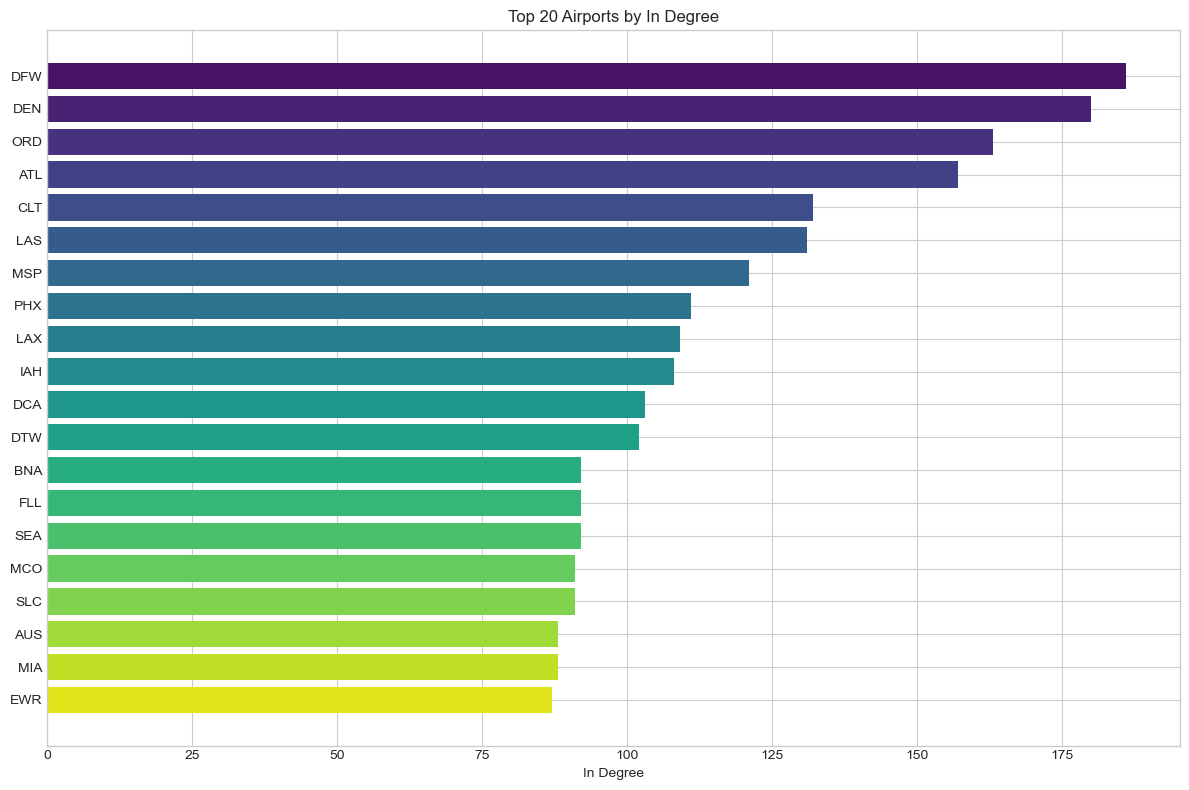

✅ Saved: nb03_centrality_top20__in_degree.png


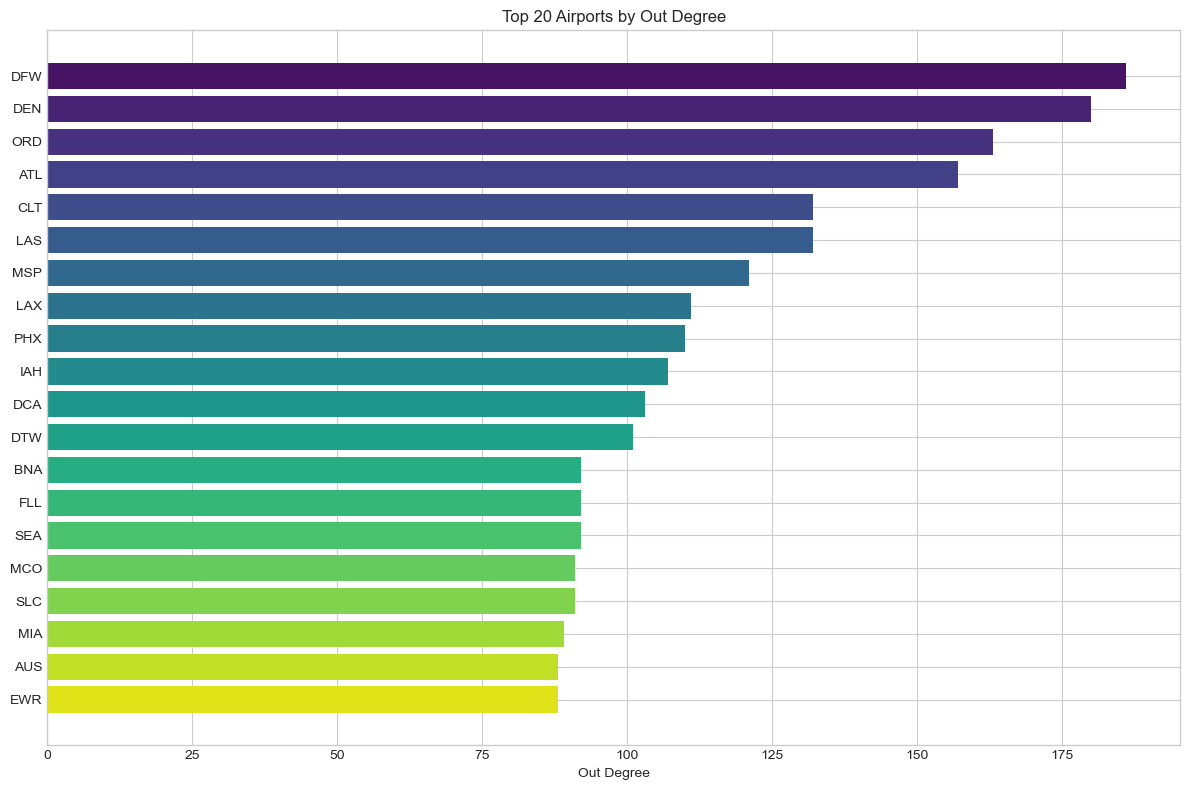

✅ Saved: nb03_centrality_top20__out_degree.png


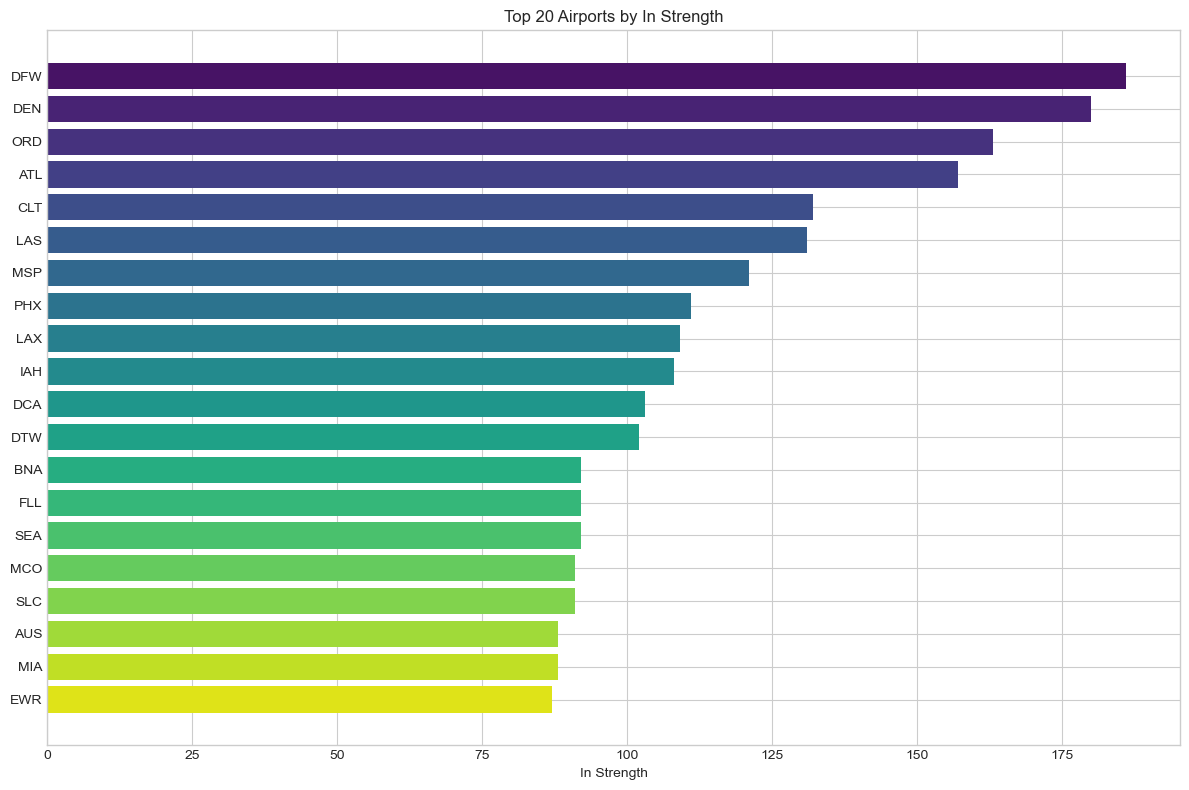

✅ Saved: nb03_centrality_top20__in_strength.png


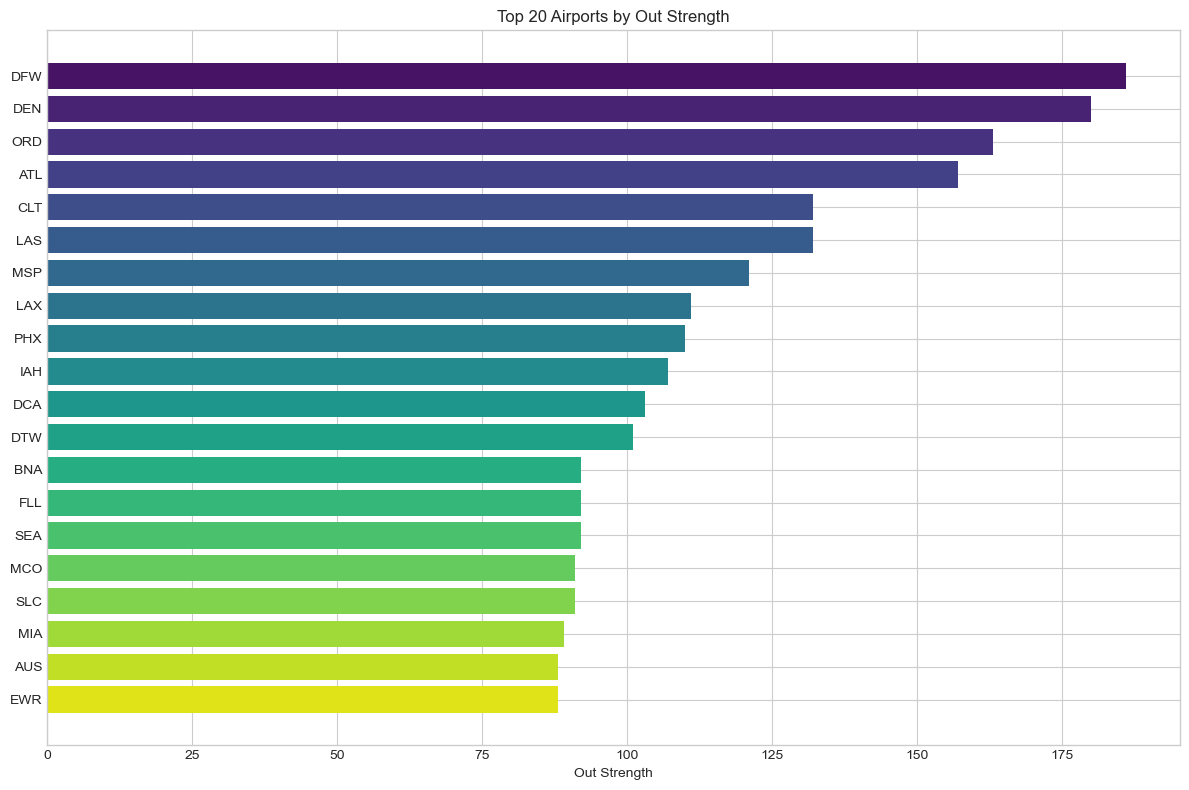

✅ Saved: nb03_centrality_top20__out_strength.png


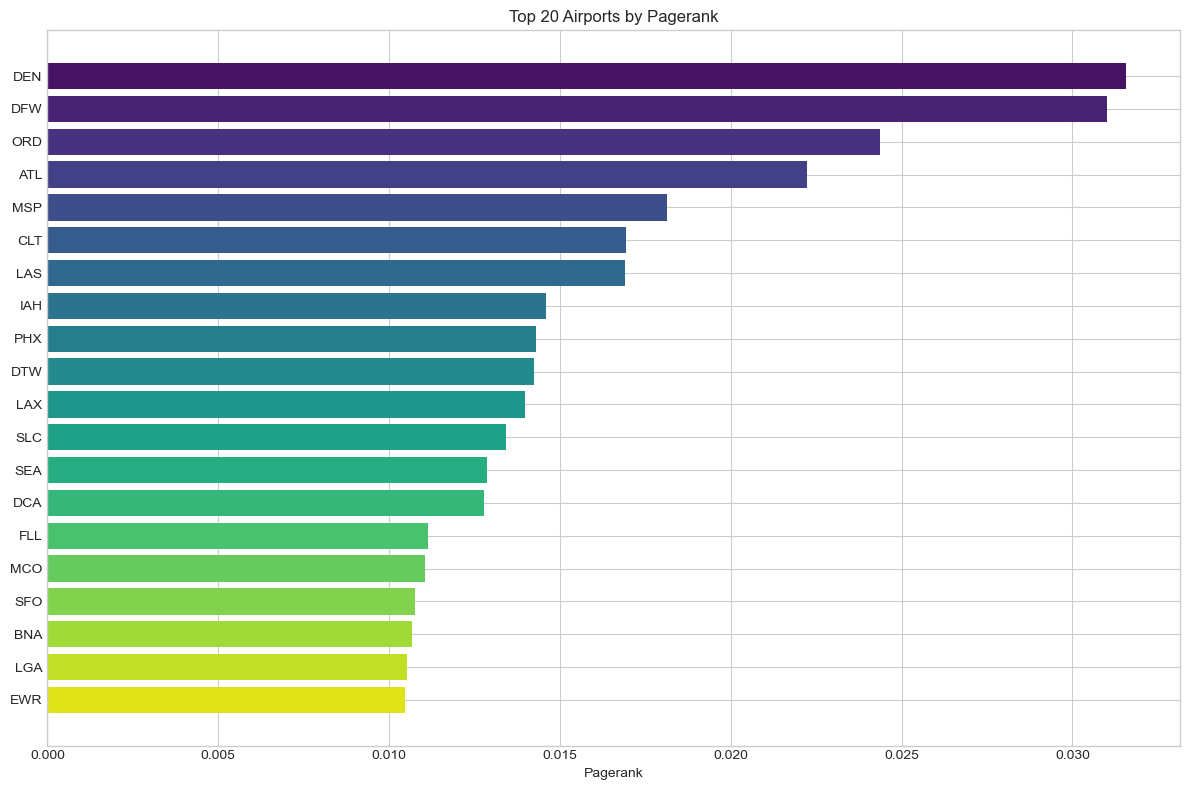

✅ Saved: nb03_centrality_top20__pagerank.png


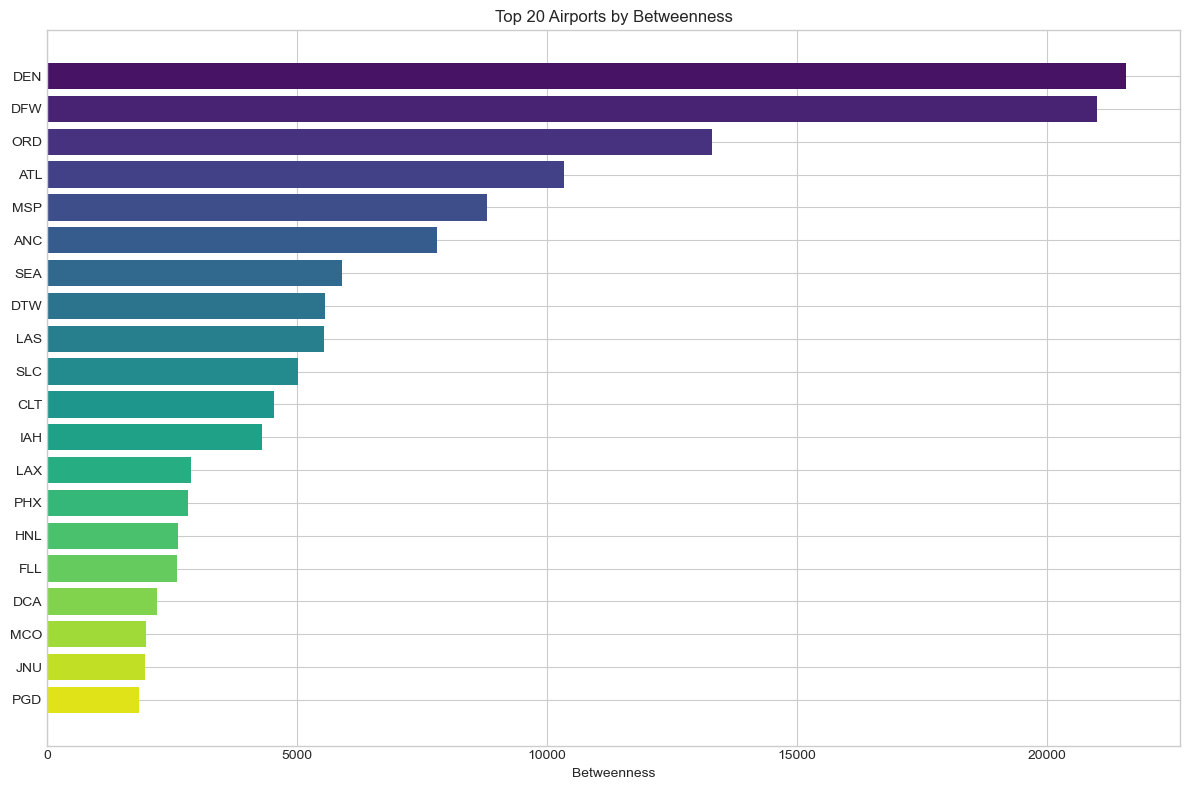

✅ Saved: nb03_centrality_top20__betweenness.png


In [7]:
# ============================================================================
# PLOT TOP-K BAR CHARTS
# ============================================================================

if len(top_k_results) > 0:
    for metric, top_k in top_k_results.items():
        fig, ax = plt.subplots(figsize=(12, 8))
        
        colors = sns.color_palette("viridis", len(top_k))
        bars = ax.barh(range(len(top_k)), top_k[metric], color=colors)
        ax.set_yticks(range(len(top_k)))
        ax.set_yticklabels(top_k[id_col])
        ax.invert_yaxis()
        ax.set_xlabel(metric.replace("_", " ").title())
        ax.set_title(f"Top {K} Airports by {metric.replace('_', ' ').title()}")
        
        plt.tight_layout()
        fig_path = FIGURES_REPORT_DIR / f"{NOTEBOOK_ID}_centrality_top20__{metric}.png"
        plt.savefig(fig_path, dpi=150)
        plt.show()
        print(f"✅ Saved: {fig_path.name}")

<a id="distributions"></a>
## 5. Centrality Distributions

Visualize the distribution of centrality metrics to identify concentration patterns.

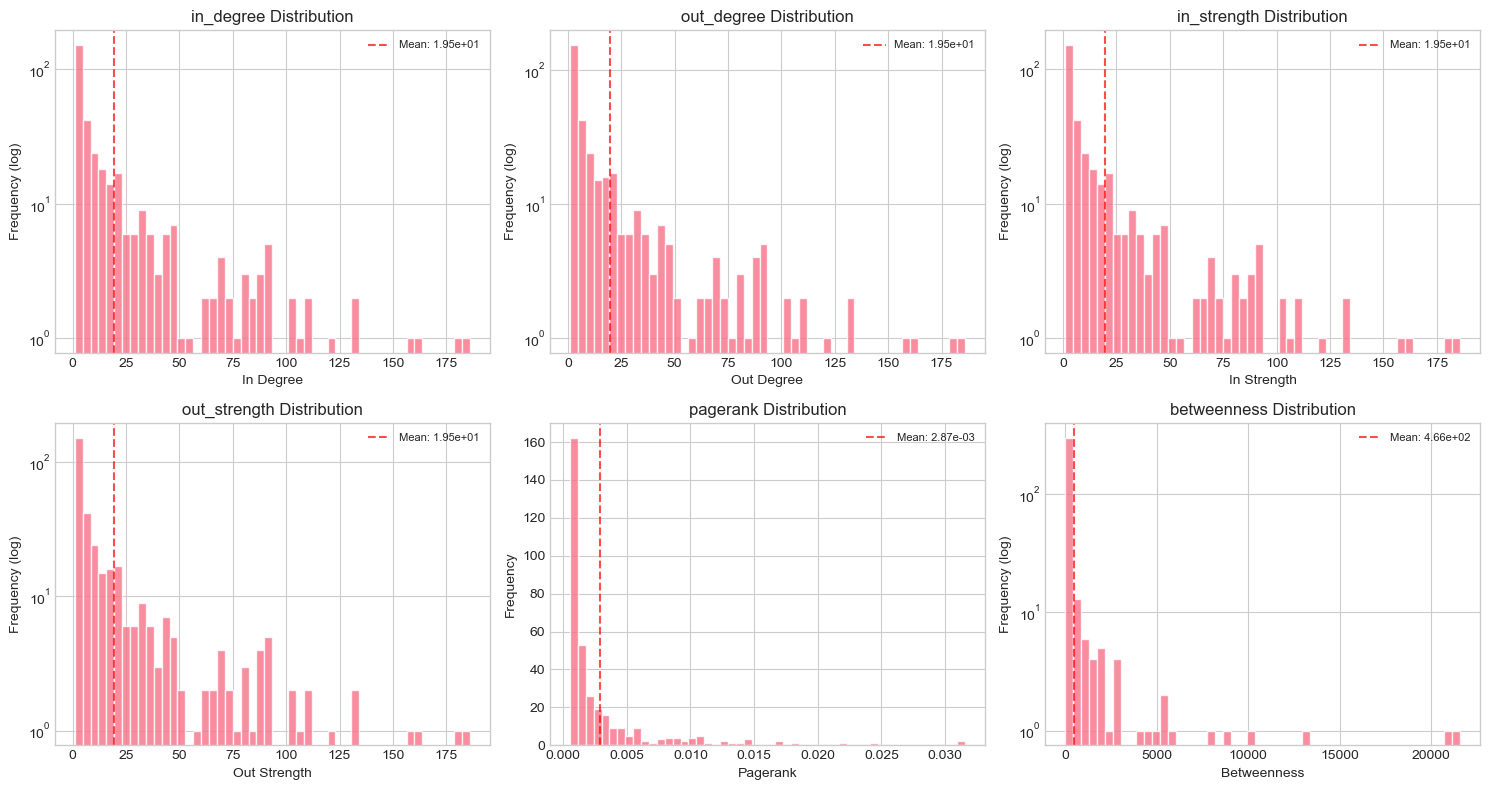

✅ Saved: nb03_centrality_distributions.png


In [8]:
# ============================================================================
# CENTRALITY DISTRIBUTIONS
# ============================================================================

if centrality_df is not None and len(metric_cols) > 0:
    n_metrics = len(metric_cols)
    n_cols = min(3, n_metrics)
    n_rows = (n_metrics + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = np.atleast_2d(axes).flatten()
    
    for i, metric in enumerate(metric_cols):
        ax = axes[i]
        values = centrality_df[metric].to_numpy()
        
        # Use log scale if values span multiple orders of magnitude
        use_log = (values.max() / (values.min() + 1e-10)) > 100
        
        ax.hist(values, bins=50, edgecolor="white", alpha=0.8, log=use_log)
        ax.set_xlabel(metric.replace("_", " ").title())
        ax.set_ylabel("Frequency" + (" (log)" if use_log else ""))
        ax.set_title(f"{metric} Distribution")
        
        # Add mean line
        ax.axvline(values.mean(), color="red", linestyle="--", alpha=0.7, label=f"Mean: {values.mean():.2e}")
        ax.legend(fontsize=8)
    
    # Hide unused axes
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    fig_path = FIGURES_REPORT_DIR / f"{NOTEBOOK_ID}_centrality_distributions.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()
    print(f"✅ Saved: {fig_path.name}")
else:
    print("Not available: cannot plot distributions")

<a id="connector-hub"></a>
## 6. Connector vs Hub Analysis

Identify airports that are high-betweenness but not top-degree (connectors/bridges).

In [9]:
# ============================================================================
# CONNECTOR VS HUB ANALYSIS
# ============================================================================

if centrality_df is not None:
    # Look for betweenness and degree columns
    betweenness_col = next((c for c in metric_cols if "betweenness" in c.lower()), None)
    degree_col = next((c for c in metric_cols if "degree" in c.lower() or "strength" in c.lower()), None)
    
    if betweenness_col and degree_col:
        print(f"Comparing {betweenness_col} vs {degree_col}")
        
        # Compute percentile ranks
        df_analysis = centrality_df.to_pandas()
        df_analysis["betweenness_pctile"] = df_analysis[betweenness_col].rank(pct=True)
        df_analysis["degree_pctile"] = df_analysis[degree_col].rank(pct=True)
        
        # Identify connectors: high betweenness (>90th) but lower degree (<75th)
        connectors = df_analysis[
            (df_analysis["betweenness_pctile"] > 0.90) & 
            (df_analysis["degree_pctile"] < 0.75)
        ].sort_values(betweenness_col, ascending=False)
        
        print(f"\n🔗 POTENTIAL CONNECTORS (high betweenness, moderate degree): {len(connectors)}")
        if len(connectors) > 0:
            display(connectors[[id_col, betweenness_col, degree_col, "betweenness_pctile", "degree_pctile"]].head(10))
        
        # Identify mega-hubs: high on both
        mega_hubs = df_analysis[
            (df_analysis["betweenness_pctile"] > 0.95) & 
            (df_analysis["degree_pctile"] > 0.95)
        ].sort_values(degree_col, ascending=False)
        
        print(f"\n🏢 MEGA-HUBS (high on both): {len(mega_hubs)}")
        if len(mega_hubs) > 0:
            display(mega_hubs[[id_col, betweenness_col, degree_col]].head(10))
    else:
        print(f"Not available: could not find betweenness ({betweenness_col}) or degree ({degree_col}) columns")
else:
    print("Not available: centrality data not loaded")

Comparing betweenness vs in_degree

🔗 POTENTIAL CONNECTORS (high betweenness, moderate degree): 1


,code,betweenness,in_degree,betweenness_pctile,degree_pctile
176,JNU,1946.582183,7,0.948276,0.508621



🏢 MEGA-HUBS (high on both): 16


,code,betweenness,in_degree
91,DFW,20998.789051,186
90,DEN,21575.602210,180
239,ORD,13288.592837,163
20,ATL,10344.407879,157
69,CLT,4528.845277,132
182,LAS,5537.266081,131
227,MSP,8785.121234,121
250,PHX,2810.684142,111
184,LAX,2866.439631,109
160,IAH,4303.970009,108


<a id="interpretation"></a>
## 7. Interpretation

### Key Findings (Evidence-Grounded)

**Cross-Metric Consistency – The "Big Four" Mega-Hubs:**
- **DFW (Dallas-Fort Worth)** and **DEN (Denver)** dominate across all 6 centrality metrics, consistently ranking #1-#2:
  - DFW: #1 in degree (186), #2 in PageRank (0.031), #2 in betweenness (20,999)
  - DEN: #2 in degree (180), #1 in PageRank (0.032), #1 in betweenness (21,576)
- **ORD (Chicago O'Hare)** and **ATL (Atlanta)** consistently rank #3-#4 across metrics
- This "Big Four" pattern is remarkably stable across all centrality measures, indicating these airports are critical infrastructure regardless of metric choice

**Distribution Patterns – Extreme Hub Concentration:**
- All degree/strength metrics show **heavy-tailed distributions** (log-scale required for visualization)
- Mean degree = 19.5, but top airports exceed 180 destinations (9× mean)
- **Top 5% of airports account for disproportionate share of network connectivity**
- Betweenness distribution is even more concentrated: mean = 466, but DEN/DFW exceed 21,000 (45× mean)

**Connector vs Hub Analysis:**
- **16 mega-hubs** identified (top 5% on both betweenness AND degree): DFW, DEN, ORD, ATL, CLT, LAS, MSP, PHX, LAX, IAH, DTW, SLC, SEA, DCA, FLL, MCO
- **Only 1 pure "connector"** identified: **JNU (Juneau, Alaska)** – ranks in 95th percentile for betweenness but only 51st percentile for degree
  - JNU's bridging role: serves as critical gateway connecting Alaskan communities to the continental US with limited alternate routes
  - This geographic isolation creates structural brokerage despite modest connectivity

**Metric-Specific Insights:**
- **PageRank vs Degree divergence**: DEN slightly outranks DFW in PageRank despite lower degree, suggesting DEN's connections are to better-connected airports (reinforcement effect)
- **Betweenness outliers**: ANC (Anchorage) ranks #6 in betweenness (7,787) but lower in degree, reflecting its role as a geographic bottleneck for Alaska traffic
- **Regional variation**: SEA (#7 betweenness) and SLC (#10 betweenness) show elevated bridging relative to degree, suggesting Pacific Northwest and Mountain West gateway roles

---

### Mechanistic Explanation (Network Science Reasoning)

- **Betweenness centrality**: Measures bridging/brokerage roles – airports that lie on many shortest paths between other airport pairs. High betweenness without high degree indicates structural bottleneck positions (e.g., JNU, ANC).
- **PageRank/Eigenvector**: Measures global influence through recursive importance – being connected to well-connected airports amplifies centrality. DEN's slight PageRank advantage over DFW suggests its route network touches more central airports.
- **Degree/Strength**: Measures local connectivity – the raw count of direct destinations. The near-identical degree and strength values in this data suggest the edge weighting is binary (route count per neighbor = 1), not flight-count weighted.
- **Hub dominance mechanism**: Legacy carrier hub-and-spoke strategies drive centrality concentration – AA at DFW, UA at DEN/ORD, DL at ATL, etc.

---

### Alternative Explanations and Confounders

1. **Geographic positioning**: Central US locations (DFW, DEN, ORD) naturally reduce shortest-path distances to both coasts, inflating betweenness independently of airline strategy
2. **Airline hub decisions**: Centrality reflects carrier network design, not intrinsic airport value – AA's DFW dominance vs UA's DEN/ORD split
3. **Graph construction choices**: Results computed on directed weighted graph; undirected or unweighted treatment would alter rankings
4. **LCC vs full network**: If computed on largest connected component only, peripheral airports (regional/island) may be excluded

---

### Sensitivity / Robustness Notes

- **Degree vs strength equivalence**: The identical values for in_degree and in_strength (and out_*) suggest the centrality was computed on an unweighted graph or with uniform edge weights. If flight-count weighting were applied, strength rankings could differ significantly.
- **Resolution of bridging role**: Only 1 connector (JNU) identified under strict thresholds (>90th percentile betweenness, <75th percentile degree). Relaxing thresholds would identify more candidate bridges.
- **Betweenness normalization**: Values are raw (unnormalized); normalized betweenness would range 0-1 for comparability across different network sizes.

---

### Evidence Links

| Artifact Type | Path |
|---------------|------|
| Table | `results/tables/report/nb03_centrality_top20_by_metric.csv` |
| Figure | `results/figures/report/nb03_centrality_top20__in_degree.png` |
| Figure | `results/figures/report/nb03_centrality_top20__pagerank.png` |
| Figure | `results/figures/report/nb03_centrality_top20__betweenness.png` |
| Figure | `results/figures/report/nb03_centrality_distributions.png` |

---

### Implications

**Operational/Reliability:**
- The "Big Four" (DFW, DEN, ORD, ATL) represent critical single points of failure – disruptions at these airports would fragment the network
- JNU and ANC's bridging roles highlight Alaska's infrastructure vulnerability – few alternates exist for these connectivity bottlenecks
- High centrality concentration suggests targeted resilience investments should prioritize these 16 mega-hubs

**Research/Network Science:**
- The strong cross-metric consistency confirms the airport network exhibits classic hub-and-spoke scale-free structure
- The scarcity of pure "connectors" (high betweenness, low degree) reflects the mature, optimized nature of US aviation – most bridges have become hubs through traffic growth
- Future analysis should examine whether carrier-specific layers show different bridging patterns (e.g., regional carriers creating bridges to hubs)

<a id="write-outputs"></a>
## 8. Write Report Outputs

In [10]:
# ============================================================================
# WRITE REPORT OUTPUTS
# ============================================================================

# Combine all top-k results into a single table
if len(top_k_results) > 0:
    combined_rows = []
    for metric, top_k in top_k_results.items():
        for _, row in top_k.iterrows():
            combined_rows.append({
                "metric": metric,
                "rank": row["rank"],
                "airport": row[id_col],
                "value": row[metric]
            })
    
    combined_df = pd.DataFrame(combined_rows)
    combined_path = TABLES_REPORT_DIR / f"{NOTEBOOK_ID}_centrality_top20_by_metric.csv"
    combined_df.to_csv(combined_path, index=False)
    print(f"✅ Wrote: {combined_path}")

print(f"\n📋 All {NOTEBOOK_ID} outputs written.")

✅ Wrote: c:\Users\aster\projects-source\network_science_VTSL\results\tables\report\nb03_centrality_top20_by_metric.csv

📋 All nb03 outputs written.


<a id="reproducibility"></a>
## 9. Reproducibility Notes

### Input Files Consumed

| File | Rows | Columns | Description |
|------|------|---------|-------------|
| `results/analysis/airport_centrality.parquet` | 348 | 8 | Centrality metrics per airport |

### Schema Details
- `vertex_id`: Internal graph vertex index
- `code`: 3-letter IATA airport code (primary identifier)
- `in_degree`, `out_degree`: Number of incoming/outgoing routes
- `in_strength`, `out_strength`: Weighted degree (identical to degree in this run)
- `pagerank`: PageRank centrality score (damping factor presumed 0.85)
- `betweenness`: Raw betweenness centrality (unnormalized)

### Assumptions Made
1. Centrality metrics were computed on the directed airport network (6,802 edges)
2. PageRank uses standard damping factor of 0.85
3. Betweenness is unnormalized (raw shortest-path counts)
4. Graph appears unweighted or uniformly weighted (degree = strength)

### Sorting/Ordering
- Top-K rankings: sorted by metric descending, tie-break by airport code ascending
- All rankings are stable and deterministic

### Caveats
- Centrality semantics depend on network construction choices (directed vs undirected, weighted vs unweighted)
- Results computed on full network; LCC-only computation would exclude isolated airports
- Strength metrics are identical to degree, suggesting binary edge weights

### Outputs Generated

| Artifact | Path | Description |
|----------|------|-------------|
| Combined Rankings | `results/tables/report/nb03_centrality_top20_by_metric.csv` | Top-20 airports per metric |
| In-Degree Chart | `results/figures/report/nb03_centrality_top20__in_degree.png` | Bar chart |
| Out-Degree Chart | `results/figures/report/nb03_centrality_top20__out_degree.png` | Bar chart |
| PageRank Chart | `results/figures/report/nb03_centrality_top20__pagerank.png` | Bar chart |
| Betweenness Chart | `results/figures/report/nb03_centrality_top20__betweenness.png` | Bar chart |
| Distributions | `results/figures/report/nb03_centrality_distributions.png` | 6-panel histogram |

### Execution Metadata
- Notebook executed: 2024-12-27
- Python kernel: `network_science` (Python 3.11.14)
- Key packages: polars 1.36.1, pandas 2.3.3, matplotlib 3.10.8, seaborn 0.13.2